라이브러리 불러오기

In [129]:
import warnings 
warnings.filterwarnings('ignore') 
import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier  
from sklearn.model_selection import train_test_split

from sklearn.metrics import log_loss

메모리 줄이는 전처리 함수

In [130]:
def reduce_mem_usage(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # 비어있는 값들 체크
    for col in df.columns:
        if df[col].dtype != object:  
            
   
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",df[col].dtype)
            
       
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            
       
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            
           
            else:
                df[col] = df[col].astype(np.float32)
            
      
            print("dtype after: ",df[col].dtype)
            print("******************************")
    

    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return df, NAlist



파일 불러오기

In [131]:
regular_season_data=pd.read_csv("C:/Users/samsung/Desktop/WNCAA/WRegularSeasonDetailedResults.csv")
Teams=pd.read_csv("C:/Users/samsung/Desktop/WNCAA/WTeams.csv")

In [124]:
Submission=pd.read_csv("C:/Users/samsung/Desktop/WNCAA/WSampleSubmissionStage2.csv")
Submission.head(5)

,ID,Pred
0,2019_3101_3113,0.5
1,2019_3101_3114,0.5
2,2019_3101_3120,0.5
3,2019_3101_3124,0.5
4,2019_3101_3125,0.5


메모리줄이기

In [132]:
regular_season_data, NAlist_1 = reduce_mem_usage(regular_season_data)
Teams, NAlist_2 = reduce_mem_usage(Teams)

Memory usage of properties dataframe is : 13.380416870117188  MB
******************************
Column:  Season
dtype before:  int64
dtype after:  uint16
******************************
******************************
Column:  DayNum
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  WTeamID
dtype before:  int64
dtype after:  uint16
******************************
******************************
Column:  WScore
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  LTeamID
dtype before:  int64
dtype after:  uint16
******************************
******************************
Column:  LScore
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  NumOT
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  WFGM
dtype before:  int64
dtype after:  uint8
************

Feature extraction 

In [133]:
#True shooting percenatge feature를 생성하고 관련된 야투 와 자유투 행을 제거한다.
regular_season_data["WTS"]=((regular_season_data["WScore"])/(2*(regular_season_data["WFGA"]+(0.44*regular_season_data["WFTA"]))))
regular_season_data["LTS"]=((regular_season_data["LScore"])/(2*(regular_season_data["LFGA"]+(0.44*regular_season_data["LFTA"]))))

#총리바운드개수 feature를 만들고 공격리바운드개수만 남긴다.
regular_season_data["WTR"]=(regular_season_data["WOR"])+(regular_season_data["WDR"])
regular_season_data["LTR"]=(regular_season_data["LOR"])+(regular_season_data["LDR"])
regular_season_data.drop('WDR',axis=1,inplace=True)
regular_season_data.drop('LDR',axis=1,inplace=True)

#TOV% feature를 생성---100개의 posession당 평균턴오버갯수
regular_season_data["WTOVP"]=((regular_season_data["WTO"])/(regular_season_data["WFGA"]+(0.44*regular_season_data["WFTA"])+regular_season_data["WTO"]))*100
regular_season_data["LTOVP"]=((regular_season_data["LTO"])/(regular_season_data["LFGA"]+(0.44*regular_season_data["LFTA"])+regular_season_data["LTO"]))*100
regular_season_data.drop('WTO',axis=1,inplace=True)
regular_season_data.drop('LTO',axis=1,inplace=True)
regular_season_data.drop('WFGM',axis=1,inplace=True)
regular_season_data.drop('WFGA',axis=1,inplace=True)
regular_season_data.drop('WFTM',axis=1,inplace=True)
regular_season_data.drop('WFTA',axis=1,inplace=True)
regular_season_data.drop('LFGM',axis=1,inplace=True)
regular_season_data.drop('LFGA',axis=1,inplace=True)
regular_season_data.drop('LFTM',axis=1,inplace=True)
regular_season_data.drop('LFTA',axis=1,inplace=True)
regular_season_data.drop('WPF',axis=1,inplace=True)
regular_season_data.drop('LPF',axis=1,inplace=True)

2010년 시즌기록으로 초기 전처리 실행

In [134]:
regular_season_data_init=regular_season_data[regular_season_data["Season"]==2010]

#2010시즌 팀명단 dataframe만들기
Teams_init=Teams
Teams_1=pd.Series(list(set(regular_season_data_init["WTeamID"]).intersection(set(Teams_init["TeamID"]))))
Teams_2=pd.Series(list(set(regular_season_data_init["LTeamID"]).intersection(set(Teams_init["TeamID"]))))
Teams_init=pd.concat([Teams_1,Teams_2],ignore_index=True).drop_duplicates().reset_index(drop=True)
Teams_init=pd.DataFrame(Teams_init)

#2011~2018시즌기록과 팀명 추가하기
for i in range(2011,2019):
   
    regular_season_data_add=regular_season_data[regular_season_data["Season"]==i]
    
    Teams_1=pd.Series(list(set(regular_season_data_add["WTeamID"]).intersection(set(Teams["TeamID"]))))
    Teams_2=pd.Series(list(set(regular_season_data_add["LTeamID"]).intersection(set(Teams["TeamID"]))))
    Teams_add=pd.concat([Teams_1,Teams_2],ignore_index=True).drop_duplicates().reset_index(drop=True)
    Teams_add=pd.DataFrame(Teams_add)
    Teams_init=pd.concat([Teams_init,Teams_add])
    regular_season_data_init=pd.concat([regular_season_data_init,regular_season_data_add])

Teams_init.rename(columns={0:"TeamID"},inplace=True)

#마진행 만들기
regular_season_data_init["Margin"]=regular_season_data_init["WScore"]-regular_season_data_init["LScore"]

#홈,원정, 중립 지역 승률 행만들기, 2010년에대해
WM=regular_season_data_init.groupby(["Season","WTeamID"]).sum()["Margin"].loc[2010,:]
LM=regular_season_data_init.groupby(["Season","LTeamID"]).sum()["Margin"].loc[2010,:]

WTS=regular_season_data_init.groupby(["Season","WTeamID"]).sum()["WTS"].loc[2010,:]
LTS=regular_season_data_init.groupby(["Season","LTeamID"]).sum()["LTS"].loc[2010,:]
WTR=regular_season_data_init.groupby(["Season","WTeamID"]).sum()["WTR"].loc[2010,:]
LTR=regular_season_data_init.groupby(["Season","LTeamID"]).sum()["LTR"].loc[2010,:]
WOR=regular_season_data_init.groupby(["Season","WTeamID"]).sum()["WOR"].loc[2010,:]
LOR=regular_season_data_init.groupby(["Season","LTeamID"]).sum()["LOR"].loc[2010,:]
WStl=regular_season_data_init.groupby(["Season","WTeamID"]).sum()["WStl"].loc[2010,:]
LStl=regular_season_data_init.groupby(["Season","LTeamID"]).sum()["LStl"].loc[2010,:]
WTOVP=regular_season_data_init.groupby(["Season","WTeamID"]).sum()["WTOVP"].loc[2010,:]
LTOVP=regular_season_data_init.groupby(["Season","LTeamID"]).sum()["LTOVP"].loc[2010,:]

WBlk=regular_season_data_init.groupby(["Season","WTeamID"]).sum()["WBlk"].loc[2010,:]
LBlk=regular_season_data_init.groupby(["Season","LTeamID"]).sum()["LBlk"].loc[2010,:]
WAst=regular_season_data_init.groupby(["Season","WTeamID"]).sum()["WAst"].loc[2010,:]
LAst=regular_season_data_init.groupby(["Season","LTeamID"]).sum()["LAst"].loc[2010,:]
HW=regular_season_data_init.groupby(["Season","WTeamID","WLoc"]).count()["DayNum"].loc[2010,:,'H']
HL=regular_season_data_init.groupby(["Season","LTeamID","WLoc"]).count()["DayNum"].loc[2010,:,'A']
AW=regular_season_data_init.groupby(["Season","WTeamID","WLoc"]).count()["DayNum"].loc[2010,:,'A']
AL=regular_season_data_init.groupby(["Season","LTeamID","WLoc"]).count()["DayNum"].loc[2010,:,'H']
NW=regular_season_data_init.groupby(["Season","WTeamID","WLoc"]).count()["DayNum"].loc[2010,:,'N']
NL=regular_season_data_init.groupby(["Season","LTeamID","WLoc"]).count()["DayNum"].loc[2010,:,'N']
HW.index.names=['Season', 'TeamID', 'WLoc']
HL.index.names=['Season', 'TeamID', 'WLoc']
WM.index.names=['Season','TeamID']
LM.index.names=['Season','TeamID']

#Margin
WM.index.names=['Season','TeamID']
LM.index.names=['Season','TeamID']
WM=pd.DataFrame(WM)
LM=pd.DataFrame(LM)
M_result=pd.merge(WM,LM,on="TeamID",how='outer').fillna(0)
M_result.columns=["WM","LM"]
M_result["Total_Margin"]=M_result["WM"]-M_result["LM"]
M_result.drop('WM',axis=1,inplace=True)
M_result.drop('LM',axis=1,inplace=True)

#Total shooting percentage
WTS.index.names=['Season','TeamID']
LTS.index.names=['Season','TeamID']
WTS=pd.DataFrame(WTS)
LTS=pd.DataFrame(LTS)
TS_result=pd.merge(WTS,LTS,on="TeamID",how='outer').fillna(0)
TS_result.columns=["WTS","LTS"]
TS_result["Total_TS"]=TS_result["WTS"]+TS_result["LTS"]
TS_result.drop('WTS',axis=1,inplace=True)
TS_result.drop('LTS',axis=1,inplace=True)

#Total Rebound 
WTR.index.names=['Season','TeamID']
LTR.index.names=['Season','TeamID']
WTR=pd.DataFrame(WTR)
LTR=pd.DataFrame(LTR)
TR_result=pd.merge(WTR,LTR,on="TeamID",how='outer').fillna(0)
TR_result.columns=["WTR","LTR"]
TR_result["Total_TR"]=TR_result["WTR"]+TR_result["LTR"]
TR_result.drop('WTR',axis=1,inplace=True)
TR_result.drop('LTR',axis=1,inplace=True)

#Offensive Rebound 
WOR.index.names=['Season','TeamID']
LOR.index.names=['Season','TeamID']
WOR=pd.DataFrame(WOR)
LOR=pd.DataFrame(LOR)
OR_result=pd.merge(WOR,LOR,on="TeamID",how='outer').fillna(0)
OR_result.columns=["WOR","LOR"]
OR_result["Total_OR"]=OR_result["WOR"]+OR_result["LOR"]
OR_result.drop('WOR',axis=1,inplace=True)
OR_result.drop('LOR',axis=1,inplace=True)

#Steal 
WStl.index.names=['Season','TeamID']
LStl.index.names=['Season','TeamID']
WStl=pd.DataFrame(WStl)
LStl=pd.DataFrame(LStl)
Stl_result=pd.merge(WStl,LStl,on="TeamID",how='outer').fillna(0)
Stl_result.columns=["WStl","LStl"]
Stl_result["Total_Stl"]=Stl_result["WStl"]+Stl_result["LStl"]
Stl_result.drop('WStl',axis=1,inplace=True)
Stl_result.drop('LStl',axis=1,inplace=True)

#Turn over percentage
WTOVP.index.names=['Season','TeamID']
LTOVP.index.names=['Season','TeamID']
WTOVP=pd.DataFrame(WTOVP)
LTOVP=pd.DataFrame(LTOVP)
TOVP_result=pd.merge(WTOVP,LTOVP,on="TeamID",how='outer').fillna(0)
TOVP_result.columns=["WTOVP","LTOVP"]
TOVP_result["Total_TOVP"]=TOVP_result["WTOVP"]+TOVP_result["LTOVP"]
TOVP_result.drop('WTOVP',axis=1,inplace=True)
TOVP_result.drop('LTOVP',axis=1,inplace=True)

#Block
WBlk.index.names=['Season','TeamID']
LBlk.index.names=['Season','TeamID']
WBlk=pd.DataFrame(WBlk)
LBlk=pd.DataFrame(LBlk)
Blk_result=pd.merge(WBlk,LBlk,on="TeamID",how='outer').fillna(0)
Blk_result.columns=["WBlk","LBlk"]
Blk_result["Total_Blk"]=Blk_result["WBlk"]+Blk_result["LBlk"]
Blk_result.drop('WBlk',axis=1,inplace=True)
Blk_result.drop('LBlk',axis=1,inplace=True)

#Assist
WAst.index.names=['Season','TeamID']
LAst.index.names=['Season','TeamID']
WAst=pd.DataFrame(WAst)
LAst=pd.DataFrame(LAst)
Ast_result=pd.merge(WAst,LAst,on="TeamID",how='outer').fillna(0)
Ast_result.columns=["WAst","LAst"]
Ast_result["Total_Ast"]=Ast_result["WAst"]+Ast_result["LAst"]
Ast_result.drop('WAst',axis=1,inplace=True)
Ast_result.drop('LAst',axis=1,inplace=True)


HW=pd.DataFrame(HW)
HL=pd.DataFrame(HL)
H_result=pd.merge(HW,HL,on="TeamID",how='outer').fillna(0)
H_result.columns=["H_W","H_L"]
H_result["H_Win_per"]=(H_result["H_W"])/(H_result["H_W"]+H_result["H_L"])
AW.index.names=['Season', 'TeamID', 'WLoc']
AL.index.names=['Season', 'TeamID', 'WLoc']
AW=pd.DataFrame(AW)
AL=pd.DataFrame(AL)
A_result=pd.merge(AW,AL,on="TeamID",how='outer').fillna(0)
A_result.columns=["A_W","A_L"]
A_result["A_Win_per"]=(A_result["A_W"])/(A_result["A_W"]+A_result["A_L"])
NW.index.names=['Season', 'TeamID', 'WLoc']
NL.index.names=['Season', 'TeamID', 'WLoc']
NW=pd.DataFrame(NW)
NL=pd.DataFrame(NL)
N_result=pd.merge(NW,NL,on="TeamID",how='outer').fillna(0)
N_result.columns=["N_W","N_L"]
N_result["N_Win_per"]=(N_result["N_W"])/(N_result["N_W"]+N_result["N_L"])
Standings_init=pd.concat([H_result,A_result,N_result,M_result,Ast_result,Blk_result,TS_result,TR_result,OR_result,Stl_result,TOVP_result], axis=1).fillna(0)
Standings_init["Season"]=2010

2011~2018년 기록을 전처리 하고 결합시킵니다.

In [135]:
for i in range(2011,2019):
    WBlk=regular_season_data_init.groupby(["Season","WTeamID"]).sum()["WBlk"].loc[i,:]
    LBlk=regular_season_data_init.groupby(["Season","LTeamID"]).sum()["LBlk"].loc[i,:]   
    WAst=regular_season_data_init.groupby(["Season","WTeamID"]).sum()["WAst"].loc[i,:]
    LAst=regular_season_data_init.groupby(["Season","LTeamID"]).sum()["LAst"].loc[i,:]   
    WM=regular_season_data_init.groupby(["Season","WTeamID"]).sum()["Margin"].loc[i,:]
    LM=regular_season_data_init.groupby(["Season","LTeamID"]).sum()["Margin"].loc[i,:]
    HW=regular_season_data_init.groupby(["Season","WTeamID","WLoc"]).count()["DayNum"].loc[i,:,'H']
    HL=regular_season_data_init.groupby(["Season","LTeamID","WLoc"]).count()["DayNum"].loc[i,:,'A']
    AW=regular_season_data_init.groupby(["Season","WTeamID","WLoc"]).count()["DayNum"].loc[i,:,'A']
    AL=regular_season_data_init.groupby(["Season","LTeamID","WLoc"]).count()["DayNum"].loc[i,:,'H']
    NW=regular_season_data_init.groupby(["Season","WTeamID","WLoc"]).count()["DayNum"].loc[i,:,'N']
    NL=regular_season_data_init.groupby(["Season","LTeamID","WLoc"]).count()["DayNum"].loc[i,:,'N']
    WTS=regular_season_data_init.groupby(["Season","WTeamID"]).sum()["WTS"].loc[i,:]
    LTS=regular_season_data_init.groupby(["Season","LTeamID"]).sum()["LTS"].loc[i,:]
    WTR=regular_season_data_init.groupby(["Season","WTeamID"]).sum()["WTR"].loc[i,:]
    LTR=regular_season_data_init.groupby(["Season","LTeamID"]).sum()["LTR"].loc[i,:]
    WOR=regular_season_data_init.groupby(["Season","WTeamID"]).sum()["WOR"].loc[i,:]
    LOR=regular_season_data_init.groupby(["Season","LTeamID"]).sum()["LOR"].loc[i,:]
    WStl=regular_season_data_init.groupby(["Season","WTeamID"]).sum()["WStl"].loc[i,:]
    LStl=regular_season_data_init.groupby(["Season","LTeamID"]).sum()["LStl"].loc[i,:]
    WTOVP=regular_season_data_init.groupby(["Season","WTeamID"]).sum()["WTOVP"].loc[i,:]
    LTOVP=regular_season_data_init.groupby(["Season","LTeamID"]).sum()["LTOVP"].loc[i,:]
    HW.index.names=['Season', 'TeamID', 'WLoc']
    HL.index.names=['Season', 'TeamID', 'WLoc']
    
    
    WM.index.names=['Season','TeamID']
    LM.index.names=['Season','TeamID']
    WM=pd.DataFrame(WM)
    LM=pd.DataFrame(LM)
    M_result=pd.merge(WM,LM,on="TeamID",how='outer').fillna(0)
    M_result.columns=["WM","LM"]
    M_result["Total_Margin"]=M_result["WM"]-M_result["LM"]
    M_result.drop('WM',axis=1,inplace=True)
    M_result.drop('LM',axis=1,inplace=True)

    #Total shooting percentage
    WTS.index.names=['Season','TeamID']
    LTS.index.names=['Season','TeamID']
    WTS=pd.DataFrame(WTS)
    LTS=pd.DataFrame(LTS)
    TS_result=pd.merge(WTS,LTS,on="TeamID",how='outer').fillna(0)
    TS_result.columns=["WTS","LTS"]
    TS_result["Total_TS"]=TS_result["WTS"]+TS_result["LTS"]
    TS_result.drop('WTS',axis=1,inplace=True)
    TS_result.drop('LTS',axis=1,inplace=True)
    
    #Total Rebound 
    WTR.index.names=['Season','TeamID']
    LTR.index.names=['Season','TeamID']
    WTR=pd.DataFrame(WTR)
    LTR=pd.DataFrame(LTR)
    TR_result=pd.merge(WTR,LTR,on="TeamID",how='outer').fillna(0)
    TR_result.columns=["WTR","LTR"]
    TR_result["Total_TR"]=TR_result["WTR"]+TR_result["LTR"]
    TR_result.drop('WTR',axis=1,inplace=True)
    TR_result.drop('LTR',axis=1,inplace=True)

    #Offensive Rebound 
    WOR.index.names=['Season','TeamID']
    LOR.index.names=['Season','TeamID']
    WOR=pd.DataFrame(WOR)
    LOR=pd.DataFrame(LOR)
    OR_result=pd.merge(WOR,LOR,on="TeamID",how='outer').fillna(0)
    OR_result.columns=["WOR","LOR"]
    OR_result["Total_OR"]=OR_result["WOR"]+OR_result["LOR"]
    OR_result.drop('WOR',axis=1,inplace=True)
    OR_result.drop('LOR',axis=1,inplace=True)
        
    #Steal 
    WStl.index.names=['Season','TeamID']
    LStl.index.names=['Season','TeamID']
    WStl=pd.DataFrame(WStl)
    LStl=pd.DataFrame(LStl)
    Stl_result=pd.merge(WStl,LStl,on="TeamID",how='outer').fillna(0)
    Stl_result.columns=["WStl","LStl"]
    Stl_result["Total_Stl"]=Stl_result["WStl"]+Stl_result["LStl"]
    Stl_result.drop('WStl',axis=1,inplace=True)
    Stl_result.drop('LStl',axis=1,inplace=True)
    
    #Turn over percentage
    WTOVP.index.names=['Season','TeamID']
    LTOVP.index.names=['Season','TeamID']
    WTOVP=pd.DataFrame(WTOVP)
    LTOVP=pd.DataFrame(LTOVP)
    TOVP_result=pd.merge(WTOVP,LTOVP,on="TeamID",how='outer').fillna(0)
    TOVP_result.columns=["WTOVP","LTOVP"]
    TOVP_result["Total_TOVP"]=TOVP_result["WTOVP"]+TOVP_result["LTOVP"]
    TOVP_result.drop('WTOVP',axis=1,inplace=True)
    TOVP_result.drop('LTOVP',axis=1,inplace=True)
    
    WBlk.index.names=['Season','TeamID']
    LBlk.index.names=['Season','TeamID']        
    WBlk=pd.DataFrame(WBlk)
    LBlk=pd.DataFrame(LBlk)
    Blk_result=pd.merge(WBlk,LBlk,on="TeamID",how='outer').fillna(0)
    Blk_result.columns=["WBlk","LBlk"]
    Blk_result["Total_Blk"]=Blk_result["WBlk"]-Blk_result["LBlk"]
    Blk_result.drop('WBlk',axis=1,inplace=True)
    Blk_result.drop('LBlk',axis=1,inplace=True)


    

    WAst.index.names=['Season','TeamID']
    LAst.index.names=['Season','TeamID']
    WAst=pd.DataFrame(WAst)
    LAst=pd.DataFrame(LAst)
    Ast_result=pd.merge(WAst,LAst,on="TeamID",how='outer').fillna(0)
    Ast_result.columns=["WAst","LAst"]
    Ast_result["Total_Ast"]=Ast_result["WAst"]+Ast_result["LAst"]
    Ast_result.drop('WAst',axis=1,inplace=True)
    Ast_result.drop('LAst',axis=1,inplace=True)
    
    HW=pd.DataFrame(HW)
    HL=pd.DataFrame(HL)
    H_result=pd.merge(HW,HL,on="TeamID",how='outer').fillna(0)
    H_result.columns=["H_W","H_L"]
    H_result["H_Win_per"]=(H_result["H_W"])/(H_result["H_W"]+H_result["H_L"])
    AW.index.names=['Season', 'TeamID', 'WLoc']
    AL.index.names=['Season', 'TeamID', 'WLoc']
    AW=pd.DataFrame(AW)
    AL=pd.DataFrame(AL)
    A_result=pd.merge(AW,AL,on="TeamID",how='outer').fillna(0)
    A_result.columns=["A_W","A_L"]
    A_result["A_Win_per"]=(A_result["A_W"])/(A_result["A_W"]+A_result["A_L"])
    NW.index.names=['Season', 'TeamID', 'WLoc']
    NL.index.names=['Season', 'TeamID', 'WLoc']
    NW=pd.DataFrame(NW)
    NL=pd.DataFrame(NL)
    N_result=pd.merge(NW,NL,on="TeamID",how='outer').fillna(0)
    N_result.columns=["N_W","N_L"]
    N_result["N_Win_per"]=(N_result["N_W"])/(N_result["N_W"]+N_result["N_L"])
    a=pd.concat([H_result,A_result,N_result,M_result,Ast_result,Blk_result,TS_result,TR_result,OR_result,Stl_result,TOVP_result], axis=1).fillna(0)
    a["Season"]=i
    Standings_init=pd.concat([Standings_init,a])

블락,턴오등의 수치를 경기당 수치로 만들어줍니다. 또한, 승률을 기준으로 팀을 4개의 티어로 분류합니다.

In [136]:
Standings_init    
Standings_init["T_Game"]=Standings_init["H_W"]+Standings_init["H_L"]+Standings_init["A_W"]+Standings_init["A_L"]+Standings_init["N_W"]+Standings_init["N_L"]
Standings_init["T_Win"]=Standings_init["H_W"]+Standings_init["A_W"]+Standings_init["N_W"]
Standings_init["T_Lose"]=Standings_init["H_L"]+Standings_init["A_L"]+Standings_init["N_L"]
Standings_init["T_WIn_Per"]=Standings_init["T_Win"]/Standings_init["T_Game"]
Standings_init["Margin_per_game"]=Standings_init["Total_Margin"]/Standings_init["T_Game"]
Standings_init["Ast_per_game"]=Standings_init["Total_Ast"]/Standings_init["T_Game"]
Standings_init["Blk_per_game"]=Standings_init["Total_Blk"]/Standings_init["T_Game"]
Standings_init["TS_per_game"]=Standings_init["Total_TS"]/Standings_init["T_Game"]
Standings_init["TR_per_game"]=Standings_init["Total_TR"]/Standings_init["T_Game"]
Standings_init["OR_per_game"]=Standings_init["Total_OR"]/Standings_init["T_Game"]
Standings_init["Stl_per_game"]=Standings_init["Total_Stl"]/Standings_init["T_Game"]
Standings_init["TOVP_per_game"]=Standings_init["Total_TOVP"]/Standings_init["T_Game"]

Teams_init=Teams_init.sort_values(by=["TeamID"])
Teams_init.index=Standings_init.index
Teams_init=Teams_init.drop(columns=["TeamID"],axis=1)
Final_Standings=pd.concat([Teams_init,Standings_init],axis=1)
Final_Standings=Final_Standings.sort_values(by=['Season',"T_WIn_Per","T_Win"], ascending=False)
Final_Standings["TeamID"]=Final_Standings.index
Final_Standings.index=range(len(Final_Standings))

#전체승률 가지고 4개의 티어로 구분
Final_Standings["Tier"]=pd.cut(Final_Standings["T_WIn_Per"],4,labels=[4,3,2,1])
Standing=Final_Standings


Standing.drop('H_W',axis=1,inplace=True)
Standing.drop('H_L',axis=1,inplace=True)
Standing.drop('A_W',axis=1,inplace=True)
Standing.drop('A_L',axis=1,inplace=True)
Standing.drop('N_W',axis=1,inplace=True)
Standing.drop('N_L',axis=1,inplace=True)
Standing.drop('T_Game',axis=1,inplace=True)
Standing.drop('T_Win',axis=1,inplace=True)
Standing.drop('T_Lose',axis=1,inplace=True)
Standing.drop('N_Win_per',axis=1,inplace=True)
Standing.drop("Total_Margin",axis=1,inplace=True)
Standing.drop("Total_Blk",axis=1,inplace=True)
Standing.drop("Total_Ast",axis=1,inplace=True)
Standing.drop("Total_TS",axis=1,inplace=True)
Standing.drop("Total_TR",axis=1,inplace=True)
Standing.drop("Total_OR",axis=1,inplace=True)
Standing.drop("Total_Stl",axis=1,inplace=True)
Standing.drop("Total_TOVP",axis=1,inplace=True)


In [39]:
Standing.head(39)

,H_Win_per,A_Win_per,Season,T_WIn_Per,Margin_per_game,Ast_per_game,Blk_per_game,TS_per_game,TR_per_game,OR_per_game,Stl_per_game,TOVP_per_game,TeamID,Tier
0,1.000000,1.000000,2018,1.000000,36.906250,22.625000,5.187500,0.619224,41.687500,11.718750,10.687500,14.647277,3163,1
1,1.000000,1.000000,2018,0.969697,26.303030,15.909091,3.575758,0.564302,37.575758,13.666667,8.696970,12.645131,3280,1
2,1.000000,0.909091,2018,0.968750,30.687500,20.343750,6.500000,0.581381,48.750000,15.000000,6.593750,15.109309,3124,1
3,0.941176,0.928571,2018,0.941176,19.647059,16.617647,3.147059,0.564252,38.264706,12.000000,8.205882,17.109863,3257,1
4,0.928571,1.000000,2018,0.937500,16.437500,16.468750,3.312500,0.511875,34.781250,12.093750,10.000000,11.735376,3273,1
5,0.923077,0.928571,2018,0.909091,17.666667,18.303030,3.424242,0.575925,42.606061,12.424242,4.363636,15.372999,3125,1
6,1.000000,0.846154,2018,0.906250,18.562500,18.843750,3.125000,0.578500,41.843750,13.906250,8.531250,16.502017,3323,1
7,1.000000,0.846154,2018,0.906250,19.125000,14.718750,2.218750,0.521915,38.812500,11.875000,8.937500,16.555476,3453,1
8,0.941176,0.750000,2018,0.882353,18.823529,19.029412,3.382353,0.603590,38.147059,11.764706,7.558824,16.226196,3332,1
9,0.846154,0.846154,2018,0.870968,11.064516,15.677419,3.774194,0.586654,41.774194,12.709677,5.741935,17.181910,3141,1


제출해야하는 파일 형식( Team1 과 Team2) 에맞게 Team1과 Team2의 기록들을 붙입니다.(훈련데이터셋 완성하기) 

In [137]:
NCAASeed=pd.read_csv("C:/Users/samsung/Desktop/WNCAA/WNCAATourneySeeds.csv")
NCAASeed["Seed"]=NCAASeed['Seed'].str.extract('(\d+)').astype(int) # 숫자만 추출해서 정수로 만들기.
a=list(NCAASeed[NCAASeed["Season"]==2010]["TeamID"])
c_init=pd.DataFrame(list(combinations(a,2)))
c_init.columns=['TeamID1','TeamID2']
t=c_init.min(axis=1)
h=c_init.max(axis=1)
c_init["TeamID1"]=t
c_init["TeamID2"]=h
c_init=c_init.sort_values(by=["TeamID1",'TeamID2'])
c_init["Season"]=np.zeros(len(c_init["TeamID1"]))
c_init=pd.DataFrame(c_init)
c_init=c_init.replace(0,2010)
for i in range(2011,2019):
    ab=list(NCAASeed[NCAASeed["Season"]==i]["TeamID"])
    c_add=pd.DataFrame(list(combinations(ab,2)))
    c_add.columns=['TeamID1','TeamID2']
    tk=c_add.min(axis=1)
    hm=c_add.max(axis=1)
    c_add["TeamID1"]=tk
    c_add["TeamID2"]=hm
    c_add=c_add.sort_values(by=["TeamID1",'TeamID2'])
    c_add["Season"]=np.zeros(len(c_add["TeamID1"]))
    c_add=pd.DataFrame(c_add)
    c_add=c_add.replace(0,i)
    c_init=pd.concat([c_init,c_add])

tournament=pd.read_csv("C:/Users/samsung/Desktop/WNCAA/WNCAATourneyCompactResults.csv")
sample=pd.read_csv("C:/Users/samsung/Desktop/WNCAA/WSampleSubmissionStage1.csv")
tournament, NAlist_3 = reduce_mem_usage(tournament)
sample, NAlist_4 = reduce_mem_usage(sample)

Train_tournament=tournament
Train_tournament["Output"]=np.zeros(len(Train_tournament.index))

Train_tournament["Output"]=(Train_tournament["WTeamID"]<Train_tournament["LTeamID"]).astype('int64')
a=pd.concat([Train_tournament["WTeamID"],Train_tournament["LTeamID"]],axis=1)
Train_tournament["TeamID1"]=a.min(axis=1)
Train_tournament["TeamID2"]=a.max(axis=1)
Train_tournament.drop('WTeamID',axis=1,inplace=True)
Train_tournament.drop('LTeamID',axis=1,inplace=True)
Train_tournament.drop('WLoc',axis=1,inplace=True)
Train_tournament.drop('NumOT',axis=1,inplace=True)
Train_tournament.drop('WScore',axis=1,inplace=True)
Train_tournament.drop('LScore',axis=1,inplace=True)
Train_tournament=Train_tournament.sort_values(["Season","TeamID1","TeamID2"])
c_init.index=range(len(c_init["Season"]))


Train_tournament.index=range(len(Train_tournament["Season"]))
target_train=pd.merge(c_init,Train_tournament).drop('DayNum',axis=1)
Standing=Standing.sort_values(["Season","TeamID"])
Standing=pd.merge(Standing,NCAASeed)

Standing.rename(columns={"TeamID":"TeamID1"}, inplace = True)
Standing_1=Standing
Final=pd.merge(Standing_1,target_train)
Final.columns
Final.rename(columns={"Stl_per_game":"T1_Stl_per_game","TOVP_per_game":"T1_TOVP_per_game","OR_per_game":"T1_OR_per_game","TR_per_game":"T1_TR_per_game","TS_per_game":"T1_TS_per_game","Blk_per_game":"T1_Blk_per_game","Ast_per_game":"T1_Ast_per_game","Margin_per_game":"T1_Margin_per_game","Seed":"T1_Seed","H_Win_per":"T1_H_Win_per","A_Win_per":"T1_A_Win_per","T_WIn_Per":"T1_T_WIn_Per","Tier":"T1_Tier"}, inplace = True)
Standing_1.rename(columns={"TeamID1":"TeamID2"}, inplace = True)


Final=pd.merge(Final,Standing_1)
Final.rename(columns={"Stl_per_game":"T2_Stl_per_game","TOVP_per_game":"T2_TOVP_per_game","OR_per_game":"T2_OR_per_game","TR_per_game":"T2_TR_per_game","TS_per_game":"T2_TS_per_game","Blk_per_game":"T2_Blk_per_game","Ast_per_game":"T2_Ast_per_game","Margin_per_game":"T2_Margin_per_game","Seed":"T2_Seed","H_Win_per":"T2_H_Win_per","A_Win_per":"T2_A_Win_per","T_WIn_Per":"T2_T_WIn_Per","Tier":"T2_Tier"}, inplace = True)
Final=Final.sort_values(["Season","TeamID1",'TeamID2'])
Final.index=range(len(Final["Season"]))





Final.drop('TeamID1',axis=1,inplace=True)
Final.drop('TeamID2',axis=1,inplace=True)
Final["T1_T_WIn_Per"]=Final["T1_T_WIn_Per"].astype(np.float64)
Final["T2_T_WIn_Per"]=Final["T2_T_WIn_Per"].astype(np.float64)
Final["T1_Seed"]=Final["T1_Seed"].astype(np.float64)
Final["T2_Seed"]=Final["T2_Seed"].astype(np.float64)
Final["T1_Tier"]=Final["T1_Tier"].astype(np.float64)
Final["T2_Tier"]=Final["T2_Tier"].astype(np.float64)
Final['T1_Margin_per_game']=Final["T1_Margin_per_game"].astype(np.float64)
Final['T2_Margin_per_game']=Final["T2_Margin_per_game"].astype(np.float64)
Final['T1_TS_per_game']=Final['T1_TS_per_game'].astype(np.float64)
Final['T2_TS_per_game']=Final['T2_TS_per_game'].astype(np.float64)
Final['T1_TR_per_game']=Final['T1_TR_per_game'].astype(np.float64)
Final['T2_TR_per_game']=Final['T2_TR_per_game'].astype(np.float64)
Final['T1_OR_per_game']=Final['T1_OR_per_game'].astype(np.float64)
Final['T2_OR_per_game']=Final['T2_OR_per_game'].astype(np.float64)
Final['T1_Stl_per_game']=Final['T1_Stl_per_game'].astype(np.float64)
Final['T2_Stl_per_game']=Final['T2_Stl_per_game'].astype(np.float64)
Final['T1_TOVP_per_game']=Final['T1_TOVP_per_game'].astype(np.float64)
Final['T2_TOVP_per_game']=Final['T2_TOVP_per_game'].astype(np.float64)

Final['T1_Ast_per_game']=Final["T1_Ast_per_game"].astype(np.float64)
Final['T2_Ast_per_game']=Final["T2_Ast_per_game"].astype(np.float64)
Final.drop('Season',axis=1,inplace=True)
Output=pd.DataFrame(Final["Output"])
Final.drop('Output',axis=1,inplace=True)


Memory usage of properties dataframe is : 0.0808258056640625  MB
******************************
Column:  Season
dtype before:  int64
dtype after:  uint16
******************************
******************************
Column:  DayNum
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  WTeamID
dtype before:  int64
dtype after:  uint16
******************************
******************************
Column:  WScore
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  LTeamID
dtype before:  int64
dtype after:  uint16
******************************
******************************
Column:  LScore
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  NumOT
dtype before:  int64
dtype after:  uint8
******************************
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  0.022787094116210938  MB
This is  28.192845

2019년 기록을 갖고 위 식을 반복(X_test 만들기)

In [138]:
regular_season_data_2019=regular_season_data[regular_season_data["Season"]==2019]

Teams_2019=Teams
Teams_1=pd.Series(list(set(regular_season_data_2019["WTeamID"]).intersection(set(Teams_2019["TeamID"]))))
    
Teams_2=pd.Series(list(set(regular_season_data_2019["LTeamID"]).intersection(set(Teams_2019["TeamID"]))))
Teams_2019=pd.concat([Teams_1,Teams_2],ignore_index=True).drop_duplicates().reset_index(drop=True)
Teams_2019=pd.DataFrame(Teams_2019)
Teams_2019.rename(columns={0:"TeamID"},inplace=True)
regular_season_data_2019["Margin"]=regular_season_data_2019["WScore"]-regular_season_data_2019["LScore"]

#홈,원정, 중립 지역 승률 행만들기

WM=regular_season_data_2019.groupby(["Season","WTeamID"]).sum()["Margin"].loc[2019,:]
LM=regular_season_data_2019.groupby(["Season","LTeamID"]).sum()["Margin"].loc[2019,:]
WBlk=regular_season_data_2019.groupby(["Season","WTeamID"]).sum()["WBlk"].loc[2019,:]
LBlk=regular_season_data_2019.groupby(["Season","LTeamID"]).sum()["LBlk"].loc[2019,:]
WAst=regular_season_data_2019.groupby(["Season","WTeamID"]).sum()["WAst"].loc[2019,:]
LAst=regular_season_data_2019.groupby(["Season","LTeamID"]).sum()["LAst"].loc[2019,:]
HW=regular_season_data_2019.groupby(["Season","WTeamID","WLoc"]).count()["DayNum"].loc[2019,:,'H']
HL=regular_season_data_2019.groupby(["Season","LTeamID","WLoc"]).count()["DayNum"].loc[2019,:,'A']
AW=regular_season_data_2019.groupby(["Season","WTeamID","WLoc"]).count()["DayNum"].loc[2019,:,'A']
AL=regular_season_data_2019.groupby(["Season","LTeamID","WLoc"]).count()["DayNum"].loc[2019,:,'H']
NW=regular_season_data_2019.groupby(["Season","WTeamID","WLoc"]).count()["DayNum"].loc[2019,:,'N']
NL=regular_season_data_2019.groupby(["Season","LTeamID","WLoc"]).count()["DayNum"].loc[2019,:,'N']
WTS=regular_season_data_2019.groupby(["Season","WTeamID"]).sum()["WTS"].loc[2019,:]
LTS=regular_season_data_2019.groupby(["Season","LTeamID"]).sum()["LTS"].loc[2019,:]
WTR=regular_season_data_2019.groupby(["Season","WTeamID"]).sum()["WTR"].loc[2019,:]
LTR=regular_season_data_2019.groupby(["Season","LTeamID"]).sum()["LTR"].loc[2019,:]
WOR=regular_season_data_2019.groupby(["Season","WTeamID"]).sum()["WOR"].loc[2019,:]
LOR=regular_season_data_2019.groupby(["Season","LTeamID"]).sum()["LOR"].loc[2019,:]
WStl=regular_season_data_2019.groupby(["Season","WTeamID"]).sum()["WStl"].loc[2019,:]
LStl=regular_season_data_2019.groupby(["Season","LTeamID"]).sum()["LStl"].loc[2019,:]
WTOVP=regular_season_data_2019.groupby(["Season","WTeamID"]).sum()["WTOVP"].loc[2019,:]
LTOVP=regular_season_data_2019.groupby(["Season","LTeamID"]).sum()["LTOVP"].loc[2019,:]

HW.index.names=['TeamID']
HL.index.names=['TeamID']


WM.index.names=['TeamID']
LM.index.names=['TeamID']
WM=pd.DataFrame(WM)
LM=pd.DataFrame(LM)
M_result=pd.merge(WM,LM,on="TeamID",how='outer').fillna(0)
M_result.columns=["WM","LM"]
M_result["Total_Margin"]=M_result["WM"]-M_result["LM"]
M_result.drop('WM',axis=1,inplace=True)
M_result.drop('LM',axis=1,inplace=True)

#Total shooting percentage
WTS.index.names=['TeamID']
LTS.index.names=['TeamID']
WTS=pd.DataFrame(WTS)
LTS=pd.DataFrame(LTS)
TS_result=pd.merge(WTS,LTS,on="TeamID",how='outer').fillna(0)
TS_result.columns=["WTS","LTS"]
TS_result["Total_TS"]=TS_result["WTS"]+TS_result["LTS"]
TS_result.drop('WTS',axis=1,inplace=True)
TS_result.drop('LTS',axis=1,inplace=True)

#Total Rebound 
WTR.index.names=['TeamID']
LTR.index.names=['TeamID']
WTR=pd.DataFrame(WTR)
LTR=pd.DataFrame(LTR)
TR_result=pd.merge(WTR,LTR,on="TeamID",how='outer').fillna(0)
TR_result.columns=["WTR","LTR"]
TR_result["Total_TR"]=TR_result["WTR"]+TR_result["LTR"]
TR_result.drop('WTR',axis=1,inplace=True)
TR_result.drop('LTR',axis=1,inplace=True)

#Offensive Rebound 
WOR.index.names=['TeamID']
LOR.index.names=['TeamID']
WOR=pd.DataFrame(WOR)
LOR=pd.DataFrame(LOR)
OR_result=pd.merge(WOR,LOR,on="TeamID",how='outer').fillna(0)
OR_result.columns=["WOR","LOR"]
OR_result["Total_OR"]=OR_result["WOR"]+OR_result["LOR"]
OR_result.drop('WOR',axis=1,inplace=True)
OR_result.drop('LOR',axis=1,inplace=True)

#Steal 
WStl.index.names=['TeamID']
LStl.index.names=['TeamID']
WStl=pd.DataFrame(WStl)
LStl=pd.DataFrame(LStl)
Stl_result=pd.merge(WStl,LStl,on="TeamID",how='outer').fillna(0)
Stl_result.columns=["WStl","LStl"]
Stl_result["Total_Stl"]=Stl_result["WStl"]+Stl_result["LStl"]
Stl_result.drop('WStl',axis=1,inplace=True)
Stl_result.drop('LStl',axis=1,inplace=True)

#Turn over percentage
WTOVP.index.names=['TeamID']
LTOVP.index.names=['TeamID']
WTOVP=pd.DataFrame(WTOVP)
LTOVP=pd.DataFrame(LTOVP)
TOVP_result=pd.merge(WTOVP,LTOVP,on="TeamID",how='outer').fillna(0)
TOVP_result.columns=["WTOVP","LTOVP"]
TOVP_result["Total_TOVP"]=TOVP_result["WTOVP"]+TOVP_result["LTOVP"]
TOVP_result.drop('WTOVP',axis=1,inplace=True)
TOVP_result.drop('LTOVP',axis=1,inplace=True)

WBlk.index.names=['TeamID']
LBlk.index.names=['TeamID']
WBlk=pd.DataFrame(WBlk)
LBlk=pd.DataFrame(LBlk)
Blk_result=pd.merge(WBlk,LBlk,on="TeamID",how='outer').fillna(0)
Blk_result.columns=["WBlk","LBlk"]
Blk_result["Total_Blk"]=Blk_result["WBlk"]-Blk_result["LBlk"]
Blk_result.drop('WBlk',axis=1,inplace=True)
Blk_result.drop('LBlk',axis=1,inplace=True)



WAst.index.names=['TeamID']
LAst.index.names=['TeamID']
WAst=pd.DataFrame(WAst)
LAst=pd.DataFrame(LAst)
Ast_result=pd.merge(WAst,LAst,on="TeamID",how='outer').fillna(0)
Ast_result.columns=["WAst","LAst"]
Ast_result["Total_Ast"]=Ast_result["WAst"]+Ast_result["LAst"]
Ast_result.drop('WAst',axis=1,inplace=True)
Ast_result.drop('LAst',axis=1,inplace=True)




HW=pd.DataFrame(HW)
HL=pd.DataFrame(HL)
H_result=pd.merge(HW,HL,on="TeamID",how='outer').fillna(0)
H_result.columns=["H_W","H_L"]
H_result["H_Win_per"]=(H_result["H_W"])/(H_result["H_W"]+H_result["H_L"])
AW.index.names=['TeamID']
AL.index.names=['TeamID']
AW=pd.DataFrame(AW)
AL=pd.DataFrame(AL)
A_result=pd.merge(AW,AL,on="TeamID",how='outer').fillna(0)
A_result.columns=["A_W","A_L"]
A_result["A_Win_per"]=(A_result["A_W"])/(A_result["A_W"]+A_result["A_L"])
NW.index.names=[ 'TeamID']
NL.index.names=[ 'TeamID']
NW=pd.DataFrame(NW)
NL=pd.DataFrame(NL)
N_result=pd.merge(NW,NL,on="TeamID",how='outer').fillna(0)
N_result.columns=["N_W","N_L"]
N_result["N_Win_per"]=(N_result["N_W"])/(N_result["N_W"]+N_result["N_L"])
Standings_2019=pd.concat([H_result,A_result,N_result,M_result,Ast_result,Blk_result,TS_result,TR_result,OR_result,Stl_result,TOVP_result], axis=1).fillna(0)
Standings_2019["Season"]=2019

Standings_2019["T_Game"]=Standings_2019["H_W"]+Standings_2019["H_L"]+Standings_2019["A_W"]+Standings_2019["A_L"]+Standings_2019["N_W"]+Standings_2019["N_L"]
Standings_2019["T_Win"]=Standings_2019["H_W"]+Standings_2019["A_W"]+Standings_2019["N_W"]
Standings_2019["T_Lose"]=Standings_2019["H_L"]+Standings_2019["A_L"]+Standings_2019["N_L"]
Standings_2019["T_WIn_Per"]=Standings_2019["T_Win"]/Standings_2019["T_Game"]
Standings_2019["Margin_per_game"]=Standings_2019["Total_Margin"]/Standings_2019["T_Game"]
Standings_2019["Ast_per_game"]=Standings_2019["Total_Ast"]/Standings_2019["T_Game"]
Standings_2019["Blk_per_game"]=Standings_2019["Total_Blk"]/Standings_2019["T_Game"]
Standings_2019["TS_per_game"]=Standings_2019["Total_TS"]/Standings_2019["T_Game"]
Standings_2019["TR_per_game"]=Standings_2019["Total_TR"]/Standings_2019["T_Game"]
Standings_2019["OR_per_game"]=Standings_2019["Total_OR"]/Standings_2019["T_Game"]
Standings_2019["Stl_per_game"]=Standings_2019["Total_Stl"]/Standings_2019["T_Game"]
Standings_2019["TOVP_per_game"]=Standings_2019["Total_TOVP"]/Standings_2019["T_Game"]

Teams_2019=Teams_2019.sort_values(by=["TeamID"])
Teams_2019.index=Standings_2019.index
Teams_2019=Teams_2019.drop(columns=["TeamID"],axis=1)
Final_Standings_2019=pd.concat([Teams_2019,Standings_2019],axis=1)
Final_Standings_2019=Final_Standings_2019.sort_values(by=['Season',"T_WIn_Per","T_Win"], ascending=False)
Final_Standings_2019["TeamID"]=Final_Standings_2019.index
Final_Standings_2019.index=range(len(Final_Standings_2019))
#전체승률 가지고 3개의 티어로 구분
Final_Standings_2019["Tier"]=pd.cut(Final_Standings_2019["T_WIn_Per"],4,labels=[4,3,2,1])
Standing_2019=Final_Standings_2019


Standing_2019.drop('H_W',axis=1,inplace=True)
Standing_2019.drop('H_L',axis=1,inplace=True)
Standing_2019.drop('A_W',axis=1,inplace=True)
Standing_2019.drop('A_L',axis=1,inplace=True)
Standing_2019.drop('N_W',axis=1,inplace=True)
Standing_2019.drop('N_L',axis=1,inplace=True)
Standing_2019.drop('T_Game',axis=1,inplace=True)
Standing_2019.drop('T_Win',axis=1,inplace=True)
Standing_2019.drop('T_Lose',axis=1,inplace=True)

Standing_2019.drop('N_Win_per',axis=1,inplace=True)
Standing_2019.drop("Total_Margin",axis=1,inplace=True)
Standing_2019.drop("Total_Blk",axis=1,inplace=True)
Standing_2019.drop("Total_Ast",axis=1,inplace=True)
Standing_2019.drop("Total_TS",axis=1,inplace=True)
Standing_2019.drop("Total_TR",axis=1,inplace=True)
Standing_2019.drop("Total_OR",axis=1,inplace=True)
Standing_2019.drop("Total_Stl",axis=1,inplace=True)
Standing_2019.drop("Total_TOVP",axis=1,inplace=True)


a_2019=list(NCAASeed[NCAASeed["Season"]==2019]["TeamID"])
c_2019=pd.DataFrame(list(combinations(a_2019,2)))
c_2019.columns=['TeamID1','TeamID2']
t=c_2019.min(axis=1)
h=c_2019.max(axis=1)
c_2019["TeamID1"]=t
c_2019["TeamID2"]=h
c_2019=c_2019.sort_values(by=["TeamID1",'TeamID2'])
c_2019["Season"]=np.zeros(len(c_2019["TeamID1"]))
c_2019=pd.DataFrame(c_2019)
c_2019=c_2019.replace(0,2019)


c_init.index=range(len(c_init["Season"]))
Standing_2019=Standing_2019.sort_values(["Season","TeamID"])
Standing_2019=pd.merge(Standing_2019,NCAASeed)

Standing_2019.rename(columns={"TeamID":"TeamID1"}, inplace = True)
Standing_1_2019=Standing_2019
Final_2019=pd.merge(Standing_1_2019,c_2019)
Final_2019.rename(columns={
"Stl_per_game":"T1_Stl_per_game","TOVP_per_game":"T1_TOVP_per_game","OR_per_game":"T1_OR_per_game","TR_per_game":"T1_TR_per_game","TS_per_game":"T1_TS_per_game",
"Blk_per_game":"T1_Blk_per_game","Ast_per_game":"T1_Ast_per_game","Margin_per_game":"T1_Margin_per_game","Seed":"T1_Seed","H_Win_per":"T1_H_Win_per","A_Win_per":"T1_A_Win_per","T_WIn_Per":"T1_T_WIn_Per","Tier":"T1_Tier"}, inplace = True)
Standing_1_2019.rename(columns={"TeamID1":"TeamID2"}, inplace = True)


Final_2019=pd.merge(Final_2019,Standing_1_2019)
Final_2019.rename(columns={
"Stl_per_game":"T2_Stl_per_game","TOVP_per_game":"T2_TOVP_per_game","OR_per_game":"T2_OR_per_game","TR_per_game":"T2_TR_per_game","TS_per_game":"T2_TS_per_game",
"Blk_per_game":"T2_Blk_per_game","Ast_per_game":"T2_Ast_per_game","Margin_per_game":"T2_Margin_per_game","Seed":"T2_Seed","H_Win_per":"T2_H_Win_per","A_Win_per":"T2_A_Win_per","T_WIn_Per":"T2_T_WIn_Per","Tier":"T2_Tier"}, inplace = True)
Final_2019=Final_2019.sort_values(["Season","TeamID1",'TeamID2'])

Final_2019.index=range(len(Final_2019["TeamID1"]))
Final_2019.drop('TeamID1',axis=1,inplace=True)
Final_2019.drop('TeamID2',axis=1,inplace=True)
Final_2019["T1_T_WIn_Per"]=Final_2019["T1_T_WIn_Per"].astype(np.float64)
Final_2019["T2_T_WIn_Per"]=Final_2019["T2_T_WIn_Per"].astype(np.float64)
Final_2019["T1_Seed"]=Final_2019["T1_Seed"].astype(np.float64)
Final_2019["T2_Seed"]=Final_2019["T2_Seed"].astype(np.float64)
Final_2019["T1_Tier"]=Final_2019["T1_Tier"].astype(np.float64)
Final_2019["T2_Tier"]=Final_2019["T2_Tier"].astype(np.float64)
Final_2019['T1_Margin_per_game']=Final_2019["T1_Margin_per_game"].astype(np.float64)
Final_2019['T2_Margin_per_game']=Final_2019["T2_Margin_per_game"].astype(np.float64)
Final_2019['T1_Ast_per_game']=Final_2019["T1_Ast_per_game"].astype(np.float64)
Final_2019['T2_Ast_per_game']=Final_2019["T2_Ast_per_game"].astype(np.float64)
Final_2019['T1_TS_per_game']=Final_2019["T1_TS_per_game"].astype(np.float64)
Final_2019['T2_TS_per_game']=Final_2019["T2_TS_per_game"].astype(np.float64)
Final_2019['T1_TR_per_game']=Final_2019["T1_TR_per_game"].astype(np.float64)
Final_2019['T2_TR_per_game']=Final_2019["T2_TR_per_game"].astype(np.float64)
Final_2019['T1_OR_per_game']=Final_2019["T1_OR_per_game"].astype(np.float64)
Final_2019['T2_OR_per_game']=Final_2019["T2_OR_per_game"].astype(np.float64)
Final_2019['T1_Stl_per_game']=Final_2019["T1_Stl_per_game"].astype(np.float64)
Final_2019['T2_Stl_per_game']=Final_2019["T2_Stl_per_game"].astype(np.float64)
Final_2019['T1_TOVP_per_game']=Final_2019["T1_TOVP_per_game"].astype(np.float64)
Final_2019['T2_TOVP_per_game']=Final_2019["T2_TOVP_per_game"].astype(np.float64)
Final_2019.drop("Season",axis=1,inplace=True)


In [390]:
X=Final
y=Output
Train=pd.DataFrame(pd.concat([X,y],axis=1))
Train["type"]=np.zeros(len(Train["T1_Seed"]))
Train[Train["T1_Seed"]==Train["T2_Seed"]]["type"]='same'
Train[(Train["T1_Seed"]<Train["T2_Seed"]) & (Train["Output"]==0)]["type"]='upset'
Train[(Train["T1_Seed"]>Train["T2_Seed"]) & (Train["Output"]==1)]["type"]='upset'

Train[(Train["T1_Seed"]<Train["T2_Seed"]) & (Train["Output"]==1)]["type"]='not_upset'
Train[(Train["T1_Seed"]>Train["T2_Seed"]) & (Train["Output"]==0)]["type"]='not_upset'

In [395]:
Train.loc[(Train["T1_Seed"]>Train["T2_Seed"]) & (Train["Output"]==0),["type"]]='not_upset'
Train.loc[(Train["T1_Seed"]<Train["T2_Seed"]) & (Train["Output"]==1),["type"]]='not_upset'
Train.loc[(Train["T1_Seed"]>Train["T2_Seed"]) & (Train["Output"]==1),["type"]]='upset'
Train.loc[(Train["T1_Seed"]<Train["T2_Seed"]) & (Train["Output"]==0),["type"]]='upset'
Train.loc[Train["T1_Seed"]==Train["T2_Seed"],["type"]]='same'


In [396]:
Train.drop("Output",axis=1,inplace=True)
Train.to_csv("C:/Users/samsung/Desktop/Train.csv",index=False)

In [143]:
Train.describe()

,T1_H_Win_per,T1_A_Win_per,T1_T_WIn_Per,T1_Margin_per_game,T1_Ast_per_game,T1_Blk_per_game,T1_TS_per_game,T1_TR_per_game,T1_OR_per_game,T1_Stl_per_game,...,T2_Ast_per_game,T2_Blk_per_game,T2_TS_per_game,T2_TR_per_game,T2_OR_per_game,T2_Stl_per_game,T2_TOVP_per_game,T2_Tier,T2_Seed,Output
count,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,...,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000
mean,0.863060,0.706954,0.797056,14.744860,15.928872,3.071691,0.531000,40.610811,13.818983,8.867454,...,14.970691,2.738696,0.522257,40.223833,13.762307,8.690698,17.900655,1.490300,6.213404,0.523810
std,0.156226,0.185389,0.118012,9.009122,2.786306,1.697093,0.036971,3.162942,1.931212,1.953188,...,2.139042,1.309039,0.031019,2.915869,2.084913,1.939054,2.028694,0.514278,4.407506,0.499874
min,0.000000,0.200000,0.468750,-5.593750,10.156250,-0.535714,0.439463,31.437500,8.593750,3.580645,...,9.862069,-0.125000,0.432047,30.733333,5.900000,4.066667,11.735376,1.000000,1.000000,0.000000
25%,0.812500,0.571429,0.709677,7.948157,13.935484,1.812500,0.504542,38.343750,12.433333,7.433333,...,13.609375,1.781250,0.500415,38.257353,12.315887,7.381048,16.567477,1.000000,3.000000,0.000000
50%,0.882353,0.727273,0.794118,13.312500,15.375000,2.766667,0.529527,40.687500,13.870968,8.818182,...,14.933333,2.529412,0.522048,40.468750,13.870968,8.612903,17.715171,1.000000,5.000000,1.000000
75%,0.947222,0.846154,0.878788,19.312500,17.303030,4.064516,0.555459,42.606061,15.015625,10.193548,...,16.193548,3.507576,0.540847,42.281250,15.187500,9.933333,19.138613,2.000000,9.000000,1.000000
max,1.000000,1.000000,1.000000,42.060606,23.343750,8.235294,0.627691,51.545455,18.468750,13.903226,...,23.343750,8.235294,0.619674,49.733333,19.733333,13.903226,24.731490,3.000000,16.000000,1.000000


X_train, y_train, X_val, y_val, X_test 정의

In [370]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2 ,random_state = 42)



KNN

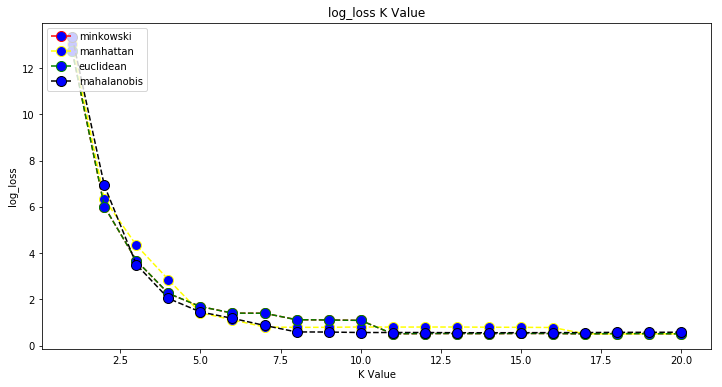

In [371]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(X_train)

X_train_scale = scaler.transform(X_train)  
X_val_scale = scaler.transform(X_val) 

from sklearn.neighbors import KNeighborsClassifier 

error_minkowski = []
error_manhattan = []
error_euclidean = []
error_mahalanobis = []

# Calculating error for K values between 1 and 20
for i in range(1, 21):  
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_scale, y_train)
    pred_i = knn.predict_proba(X_val_scale)
    error_minkowski.append(log_loss(y_val, pred_i))

for i in range(1, 21):  
    knn = KNeighborsClassifier(n_neighbors=i,metric='manhattan')
    knn.fit(X_train_scale, y_train)
    pred_i = knn.predict_proba(X_val_scale)
    error_manhattan.append(log_loss(y_val, pred_i))

for i in range(1, 21):  
    knn = KNeighborsClassifier(n_neighbors=i,metric='euclidean')
    knn.fit(X_train_scale, y_train)
    pred_i = knn.predict_proba(X_val_scale)
    error_euclidean.append(log_loss(y_val, pred_i))

for i in range(1, 21):  
    cov = np.cov(X_train_scale, rowvar=False)
    knn = KNeighborsClassifier(n_neighbors=i,metric='mahalanobis', metric_params=dict(V=cov))
    knn.fit(X_train_scale, y_train)
    pred_i = knn.predict_proba(X_val_scale)
    error_mahalanobis.append(log_loss(y_val, pred_i))

import matplotlib.pyplot as plt
    
plt.figure(figsize=(12, 6))  
plt.plot(range(1, 21), error_minkowski, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10,label="a")

plt.plot(range(1, 21), error_manhattan, color='yellow', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10,label="a")

plt.plot(range(1, 21), error_euclidean, color='green', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10,label="a")

plt.plot(range(1, 21), error_mahalanobis, color='black', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10,label="a")
plt.legend(['minkowski', 'manhattan', 'euclidean','mahalanobis'], loc='upper left')
plt.title('log_loss K Value')  
plt.xlabel('K Value')  
plt.ylabel('log_loss')  
plt.show()

In [373]:
# 최적의 k와 distance measure

knn_final = KNeighborsClassifier(n_neighbors=6,metric='manhattan')
knn.fit(X_train_scale, y_train)
pred_knn = knn.predict_proba(X_val_scale)
print(knn.__class__.__name__+" log_loss is %2.3f" % log_loss(y_val, pred_knn))

KNeighborsClassifier log_loss is 0.581


나이브 베이즈 

In [374]:
from sklearn.naive_bayes import GaussianNB
NB = GaussianNB()
NB.fit(X_train_scale, y_train)
pred_NB = NB.predict_proba(X_val_scale)
print(NB.__class__.__name__+" log_loss is %2.3f" % log_loss(y_val, pred_NB))

GaussianNB log_loss is 0.946


로지스틱 리그레션

In [375]:
import warnings 
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_proba = logreg.predict_proba(X_val)
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_val, y_pred_proba))

LogisticRegression log_loss is 0.440


로지스틱 리그레션 parameter tuning 시도

In [376]:
import warnings 
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
pipe = Pipeline([('classifier' , RandomForestClassifier())])
param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2' ],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']}
]

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)
# Fit on data
logreg = clf.fit(X_train, y_train)
y_pred_proba_best = logreg.predict_proba(X_val)
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_val, y_pred_proba_best))

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


GridSearchCV log_loss is 0.444


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.7s finished


In [379]:
param_grid

[{'classifier': [LogisticRegression(C=0.012742749857031334, class_weight=None, dual=False,
             fit_intercept=True, intercept_scaling=1, max_iter=100,
             multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
             solver='liblinear', tol=0.0001, verbose=0, warm_start=False)],
  'classifier__penalty': ['l1', 'l2'],
  'classifier__C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
         4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
         2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
         1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
         5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
  'classifier__solver': ['liblinear']}]

Support vector classify

In [380]:
from sklearn import svm
svm=svm.SVC(probability=True)
svc=svm.fit(X_train, y_train)
y_pred_proba_best = svc.predict_proba(X_val)
print(svc.__class__.__name__+" log_loss is %2.3f" % log_loss(y_val, y_pred_proba_best))


SVC log_loss is 0.562


In [381]:
from sklearn import svm
import warnings 
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
pipe = Pipeline([('classifier' , RandomForestClassifier())])
param_grid = [
    {'classifier' : [svm.SVC(probability=True)],
     'classifier__kernel' : ['linear', 'rbf', 'poly'],
    'classifier__C' : [0.001, 0.01, 0.1, 1, 10],
    'classifier__gamma' : [0.001, 0.01, 0.1, 1,10],
    'classifier__degree' : [ 1, 2, 3]
    }
]

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)
svm = clf.fit(X_train, y_train)
y_pred_proba_best = svm.predict_proba(X_val)
print(svm.__class__.__name__+" log_loss is %2.3f" % log_loss(y_val, y_pred_proba_best))



Fitting 5 folds for each of 225 candidates, totalling 1125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 849 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1125 out of 1125 | elapsed:  8.4min finished


GridSearchCV log_loss is 0.465


In [172]:
param_grid


[{'classifier': [SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=1, gamma=0.001, kernel='linear',
     max_iter=-1, probability=True, random_state=None, shrinking=True,
     tol=0.001, verbose=False)],
  'classifier__kernel': ['linear', 'rbf', 'poly'],
  'classifier__C': [0.001, 0.01, 0.1, 1, 10],
  'classifier__gamma': [0.001, 0.01, 0.1, 1, 10],
  'classifier__degree': [1, 2, 3]}]

Desicion Tree

In [174]:
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier()
DT.fit(X_train, y_train)
y_pred_proba = DT.predict_proba(X_val)
print(DT.__class__.__name__+" log_loss is %2.3f" % log_loss(y_val, y_pred_proba))

DecisionTreeClassifier log_loss is 11.210


In [180]:
pipe = Pipeline([('classifier' , RandomForestClassifier())])
param_grid = [
    {'classifier' : [DecisionTreeClassifier()],
     'classifier__criterion' : ['gini', 'entropy'],
    'classifier__max_depth' : [5,10,20,30,50,100],
    'classifier__min_samples_leaf' : [3,4,5,6,7],
    'classifier__min_samples_split' : [6, 8, 12, 15]
    }
]

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)
DT = clf.fit(X_train, y_train)
y_pred_proba_best = DT.predict_proba(X_val)
print(DT.__class__.__name__+" log_loss is %2.3f" % log_loss(y_val, y_pred_proba_best))


Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 336 tasks      | elapsed:    0.6s


GridSearchCV log_loss is 0.565


[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    1.4s finished


In [181]:
param_grid

[{'classifier': [DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
               max_features=None, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=7, min_samples_split=12,
               min_weight_fraction_leaf=0.0, presort=False, random_state=None,
               splitter='best')],
  'classifier__criterion': ['gini', 'entropy'],
  'classifier__max_depth': [5, 10, 20, 30, 50, 100],
  'classifier__min_samples_leaf': [3, 4, 5, 6, 7],
  'classifier__min_samples_split': [6, 8, 12, 15]}]

In [346]:
from sklearn.tree import  export_graphviz
import pydot
DT = DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
               max_features=None, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=7, min_samples_split=12,
               min_weight_fraction_leaf=0.0, presort=False, random_state=None,
               splitter='best')
DT.fit(X_train, y_train)
export_graphviz(DT, out_file="dicisionTree1.dot", class_names=["A","B","C"],
                feature_names=X_train.columns, impurity=False, filled=True)

(graph,) = pydot.graph_from_dot_file('dicisionTree1.dot', encoding='utf8')

#Dot 파일을 Png 이미지로 저장
graph.write_png('dicisionTree1.png')


AdaBoostClassfier

In [311]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)
y_pred_proba_ada = ada.predict_proba(X_val).clip(0,1)
print(ada.__class__.__name__+" log_loss is %2.3f" % log_loss(y_val, y_pred_proba_ada))

AdaBoostClassifier log_loss is 0.605


AdaBoostClassfier parameter tuning 시도

In [193]:
crossvalidation=KFold(n_splits=10,shuffle=True,random_state=1)
search_grid={'n_estimators':[5,10,20,50,100],'learning_rate':[0.007,0.01,0.05,0.1,0.2,0.5]}
search=GridSearchCV(estimator=ada,param_grid=search_grid,scoring='neg_log_loss',n_jobs=1,cv=crossvalidation)
search.fit(X_train,y_train)
search.best_params_

{'learning_rate': 0.5, 'n_estimators': 100}

In [312]:
ada_tuned = AdaBoostClassifier(learning_rate= 0.5, n_estimators= 10)
ada_tuned.fit(X_train, y_train)
y_pred_proba_ada_tuned = ada_tuned.predict_proba(X_val).clip(0,1)
print(ada_tuned.__class__.__name__+" log_loss is %2.3f" % log_loss(y_val, y_pred_proba_ada_tuned))

AdaBoostClassifier log_loss is 0.547


GradientBoostingClassifier

In [329]:
from sklearn.ensemble import GradientBoostingClassifier 
GB = GradientBoostingClassifier()
GB.fit(X_train, y_train)
y_pred_proba_GB = GB.predict_proba(X_val)
print(GB.__class__.__name__+" log_loss is %2.3f" % log_loss(y_val, y_pred_proba_GB))

GradientBoostingClassifier log_loss is 0.478


GradientBoostingClassifier parameter tuning 시도

In [330]:
crossvalidation=KFold(n_splits=10,shuffle=True,random_state=1)
search_grid={'n_estimators':[10,50,100,150,300],'learning_rate':[0.007,0.01,0.05,0.1,0.2,0.5]}
search=GridSearchCV(estimator=GB,param_grid=search_grid,scoring='neg_log_loss',n_jobs=1,cv=crossvalidation)
search.fit(X_train,y_train)
search.best_params_

{'learning_rate': 0.01, 'n_estimators': 300}

In [331]:
GB_tuned = GradientBoostingClassifier(learning_rate= 0.01, n_estimators= 300)
GB_tuned.fit(X_train, y_train)
y_pred_proba_GB_tuned = GB_tuned.predict_proba(X_val)
print(GB_tuned.__class__.__name__+" log_loss is %2.3f" % log_loss(y_val, y_pred_proba_GB_tuned))

GradientBoostingClassifier log_loss is 0.458


LinearDiscriminantAnalysis

In [316]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
LDA= LinearDiscriminantAnalysis()
LDA.fit(X_train, y_train)
y_pred_proba_LDA = LDA.predict_proba(X_val)
print(LDA.__class__.__name__+" log_loss is %2.3f" % log_loss(y_val, y_pred_proba_LDA))

LinearDiscriminantAnalysis log_loss is 0.457


In [322]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier()
RF.fit(X_train, y_train)
y_pred_proba = RF.predict_proba(X_val)
print(RF.__class__.__name__+" log_loss is %2.3f" % log_loss(y_val, y_pred_proba))

RandomForestClassifier log_loss is 0.573


In [325]:
pipe = Pipeline([('classifier' , RandomForestClassifier())])
param_grid = [
    {'classifier' : [RandomForestClassifier()],

     'classifier__n_estimators' : [100,200,300,1000],
     'classifier__criterion' : ['gini', 'entropy'],
    'classifier__max_depth' : [5,10,20,30],
    'classifier__min_samples_leaf' : [3,4,5,6],
    'classifier__min_samples_split' : [8, 12, 15]
    }
]

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)
RF = clf.fit(X_train, y_train)
y_pred_proba_best = RF.predict_proba(X_val)
print(RF.__class__.__name__+" log_loss is %2.3f" % log_loss(y_val, y_pred_proba_best))


Fitting 5 folds for each of 384 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   54.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  4.1min


GridSearchCV log_loss is 0.454


[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed:  4.4min finished


In [326]:
param_grid

[{'classifier': [RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
               max_depth=5, max_features='auto', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=6, min_samples_split=12,
               min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
               oob_score=False, random_state=None, verbose=0,
               warm_start=False)],
  'classifier__n_estimators': [100, 200, 300, 1000],
  'classifier__criterion': ['gini', 'entropy'],
  'classifier__max_depth': [5, 10, 20, 30],
  'classifier__min_samples_leaf': [3, 4, 5, 6],
  'classifier__min_samples_split': [8, 12, 15]}]

앙상블기법

In [342]:
seed = 7 
processors=1 
num_folds=10
num_instances=len(X) 
score='neg_log_loss'
kfold =KFold(n_splits=num_folds, random_state=seed)
models = [] 
models.append(('LR',  LogisticRegression(C=0.004832930238571752, class_weight=None, dual=False,
             fit_intercept=True, intercept_scaling=1, max_iter=100,
             multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
             solver='liblinear', tol=0.0001, verbose=0, warm_start=False))) 
models.append(('SVM', SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=1, gamma=0.001, kernel='linear',
     max_iter=-1, probability=True, random_state=None, shrinking=True,
     tol=0.001, verbose=False)))
models.append(('GB',  GradientBoostingClassifier(learning_rate= 0.01, n_estimators= 300)))  
models.append(('LDA',LinearDiscriminantAnalysis())) 
results = [] 
names = [] 
for name, model in models:     
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=score, n_jobs=processors)     
    results.append(cv_results)     
    names.append(name)     
    print("{0}: ({1:.3f}) +/- ({2:.3f})".format(name, cv_results.mean(), cv_results.std()))
    
    
estimators = [] 
estimators.append(('LR', LogisticRegression(C=0.004832930238571752, class_weight=None, dual=False,
             fit_intercept=True, intercept_scaling=1, max_iter=100,
             multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
             solver='liblinear', tol=0.0001, verbose=0, warm_start=False))) 
estimators.append(('SVM', SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=1, gamma=0.001, kernel='linear',
     max_iter=-1, probability=True, random_state=None, shrinking=True,
     tol=0.001, verbose=False))) 
estimators.append(('GB', GradientBoostingClassifier(learning_rate= 0.01, n_estimators= 300)))
estimators.append(('LDA', LinearDiscriminantAnalysis())) 
# create the ensemble model 
ensemble = VotingClassifier(estimators, voting='soft', weights=[1,1,1,1])
ensemble.fit(X_train, y_train) 
y_pred_proba_essemble = ensemble.predict_proba(X_val)
print(ensemble.__class__.__name__+" log_loss is %2.3f" % log_loss(y_val, y_pred_proba_essemble))

LR: (-0.443) +/- (0.066)
SVM: (-0.442) +/- (0.069)
GB: (-0.502) +/- (0.082)
LDA: (-0.456) +/- (0.088)
VotingClassifier log_loss is 0.433


In [343]:
# for loop를 사용해 최적 weight 찾기
a=[1,3,9,27,81]
index_df=pd.DataFrame(columns=["i","j","k","m"])
log_loss_=[]
for i in range(5):
    for j in range(5):
        for k in range(5):
            for m in range(5):
                ensemble = VotingClassifier(estimators, voting='soft', weights=[a[i],a[j],a[k],a[m]])
                ensemble.fit(X_train, y_train) 
                y_pred_proba_essemble = ensemble.predict_proba(X_val)
                log_loss_.append(log_loss(y_val, y_pred_proba_essemble))
                index_df_add = pd.DataFrame(np.transpose(pd.DataFrame([i,j,k,m])),columns=["i","j","k","m"])
                index_df=pd.concat([index_df,index_df_add])



In [352]:
print(log_loss_.index(min(log_loss_)))   #최적의 weight --> 1,81,81,81
print(min(log_loss_))

ensemble = VotingClassifier(estimators, voting='soft', weights=[1,81,81,81])
ensemble.fit(X_train, y_train) 
y_pred_proba_essemble = ensemble.predict_proba(X_val)
print(ensemble.__class__.__name__+" log_loss is %2.3f" % log_loss(y_val, y_pred_proba_essemble))

124
0.43080690940903493
VotingClassifier log_loss is 0.431
VotingClassifier log_loss is 0.496


XGBOOST

In [332]:
import xgboost as xgb
def run_xgb(train_X, train_y, val_X, val_y, test_X):
    params = {'objective': 'binary:logistic', 
          'eval_metric': 'logloss',
          'eta': 0.01,
              'n_estimators': 1000,
          'max_depth': 3, 
          'subsample': 0.8, 
          'colsample_bytree': 1,
          'alpha':0.01,
        'gamma':1,
          'random_state': 42, 
          'silent': True}
    
    tr_data = xgb.DMatrix(train_X, train_y)
    va_data = xgb.DMatrix(val_X, val_y)
    
    watchlist = [(tr_data, 'train'), (va_data, 'valid')]
    
    model_xgb = xgb.train(params, tr_data, 2000, watchlist, maximize=False, early_stopping_rounds = 100, verbose_eval=100)
    
    dtest = xgb.DMatrix(test_X)
    xgb_pred_y = model_xgb.predict(dtest, ntree_limit=model_xgb.best_ntree_limit)
    
    return xgb_pred_y, model_xgb


pred_test_xgb, model_xgb = run_xgb(X_train, y_train, X_val, y_val, X_test)

[0]	train-logloss:0.688782	valid-logloss:0.689536
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[100]	train-logloss:0.448893	valid-logloss:0.515236
[200]	train-logloss:0.356076	valid-logloss:0.472452
[300]	train-logloss:0.300976	valid-logloss:0.458731
[400]	train-logloss:0.262266	valid-logloss:0.450408
[500]	train-logloss:0.229527	valid-logloss:0.446123
[600]	train-logloss:0.202644	valid-logloss:0.443833
[700]	train-logloss:0.18104	valid-logloss:0.44565
Stopping. Best iteration:
[638]	train-logloss:0.194365	valid-logloss:0.441697



In [334]:
print(model_xgb.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, pred_test_xgb))

Booster log_loss is 0.540


In [ ]:
 model_xgb

LGBM

In [67]:
import lightgbm as lgb


params = {'objective' : "binary", 
               'boost':"gbdt",
               'metric':"binary_logloss",
               'boost_from_average':"false",
               'num_threads':8,
               'learning_rate' : 0.01,
               'num_leaves' : 8,
               'max_depth':3,
               'tree_learner' : "serial",
               'feature_fraction' : 0.05,
               'bagging_freq' : 5,
               'bagging_fraction' : 0.4,
               'min_data_in_leaf' : 80,
               'min_sum_hessian_in_leaf' : 10.0,
               'verbosity' : 1}
import time

In [69]:
from sklearn.model_selection import StratifiedKFold
fold_n=20
folds = StratifiedKFold(n_splits=fold_n, shuffle=True, random_state=10)


y_pred_lgb = np.zeros(len(Final_2019))
num_round = 10000000
for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y)):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
        
    lgb_model = lgb.train(params,train_data,num_round,#change 20 to 2000
                    valid_sets = [train_data, valid_data],verbose_eval=5000,early_stopping_rounds = 3500)##change 10 to 200
            
    y_pred_lgb += lgb_model.predict(Final_2019, num_iteration=lgb_model.best_iteration)/20


Fold 0 started at Sun Jun  2 22:47:22 2019
Training until validation scores don't improve for 3500 rounds.
[5000]	training's binary_logloss: 0.433338	valid_1's binary_logloss: 0.357951
[10000]	training's binary_logloss: 0.402283	valid_1's binary_logloss: 0.335418
[15000]	training's binary_logloss: 0.383191	valid_1's binary_logloss: 0.325125
[20000]	training's binary_logloss: 0.368002	valid_1's binary_logloss: 0.321397
Early stopping, best iteration is:
[16513]	training's binary_logloss: 0.378014	valid_1's binary_logloss: 0.313983
Fold 1 started at Sun Jun  2 22:47:40 2019
Training until validation scores don't improve for 3500 rounds.
Early stopping, best iteration is:
[184]	training's binary_logloss: 0.604488	valid_1's binary_logloss: 0.678962
Fold 2 started at Sun Jun  2 22:47:43 2019
Training until validation scores don't improve for 3500 rounds.
[5000]	training's binary_logloss: 0.422262	valid_1's binary_logloss: 0.534624
[10000]	training's binary_logloss: 0.389784	valid_1's binary

RandomForest 중요변수 추출

In [327]:
rfc_model = RandomForestClassifier() 
rfc_model.fit(X_train, y_train) 
feature_imp = pd.DataFrame(rfc_model.feature_importances_, index=X.columns, columns=["importance"]) 
feat_imp_20 =pd.DataFrame(np.transpose(feature_imp.sort_values("importance", ascending=False).head(20)))
feat_imp_20

,T2_Seed,T1_Margin_per_game,T2_Margin_per_game,T1_A_Win_per,T1_Blk_per_game,T1_Seed,T2_TOVP_per_game,T2_TR_per_game,T2_T_WIn_Per,T1_TR_per_game,T1_Stl_per_game,T1_T_WIn_Per,T1_H_Win_per,T1_Ast_per_game,T2_TS_per_game,T1_OR_per_game,T1_TS_per_game,T1_TOVP_per_game,T2_Blk_per_game,T2_Stl_per_game
importance,0.156127,0.127244,0.073596,0.048201,0.043674,0.040776,0.040581,0.038868,0.036056,0.035496,0.033287,0.03238,0.032182,0.031705,0.029116,0.028542,0.027583,0.025902,0.025408,0.022029


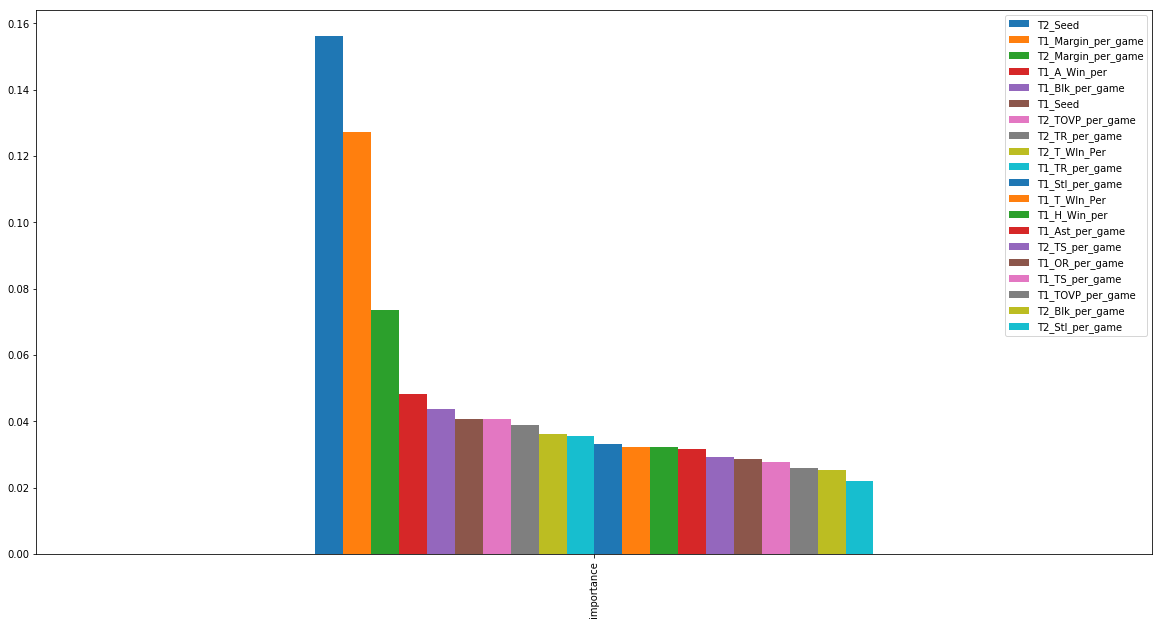

In [328]:
import matplotlib.pyplot as plt
feat_imp_20.plot(kind='bar',figsize=(20,10))

plt.show()

Permutation Importanace

In [72]:
import eli5

from eli5.sklearn import PermutationImportance
perm = PermutationImportance(rfc_model, random_state=1).fit(X_val, y_val)
eli5.show_weights(perm, feature_names = X_val.columns.tolist(), top=26)

Weight,Feature
0.0825 ± 0.0361,T1_Seed
0.0561 ± 0.0263,T2_Seed
0.0421 ± 0.0406,T1_Margin_per_game
0.0368 ± 0.0131,T1_Blk_per_game
0.0333 ± 0.0233,T2_A_Win_per
0.0281 ± 0.0258,T2_Stl_per_game
0.0228 ± 0.0306,T2_Blk_per_game
0.0193 ± 0.0131,T1_H_Win_per
0.0193 ± 0.0131,T2_T_WIn_Per
0.0175 ± 0.0111,T1_Stl_per_game


Randomforest 기법을 통해 변수별 중요도를 파악하고 feature selection을 시도 했으나 validation set에대한 지표가 모든 변수를 사용하는것이 좋게 나와서 모든변수를 사용해서 예측파일을 만듭니다.

In [79]:
#앙상블기법 예측파일 만들기
preds_e = ensemble.predict_proba(Final_2019) 
Submission=pd.read_csv("C:/Users/samsung/Desktop/WNCAA/WSampleSubmissionStage2.csv")
Submission["Pred"]=preds_e
Submission.index=Submission["ID"]
Submission.drop("ID",axis=1,inplace=True)
Submission.to_csv("C:/Users/samsung/Desktop/submission_Ensemble.csv")


 
